### Cartpole Problem

References:
- [Hands on RL Policy Gradient](https://github.com/PacktPublishing/Hands-on-Reinforcement-Learning-with-PyTorch/blob/master/Section%204/4.3%20Policy%20Gradients%20REINFORCE.ipynb)<br>
- [Policy Gradient Math](https://towardsdatascience.com/policy-gradients-in-reinforcement-learning-explained-ecec7df94245)<br>
- [Vanilla Policy Gradient](https://spinningup.openai.com/en/latest/algorithms/vpg.html)<br>
- [RL by Phil Tabor](https://github.com/philtabor/Youtube-Code-Repository/tree/master/ReinforcementLearning)

We implement the OpenAiGym Cartpole problem using the REINFORCE algorithm. This is the most basic policy gradient algorithm. 

In [1]:
import os

from collections import deque
import importlib
import torch as T
import gymnasium as gym

import policygradient
importlib.reload(policygradient)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from IPython.display import clear_output

### Initializing the Environment

In [2]:
env_id = "CartPole-v1"
env = gym.make(env_id)#,render_mode="human")

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("The State Space is: ", a_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  4
The State Space is:  2
Sample observation [-2.5525031e+00 -1.1581503e+38 -3.7722964e-02  3.0538007e+38]


In [3]:
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")

In [4]:
layer1 = 32
layer2 = 64
gamma = 0.998
learning_rate = 0.0001
episodes = 100_000

# Average window size. The size of the sliding window
# used to calculate the mean reward across the last N episodes
# where N is the avg_win_size

avg_win_size = 50
epi_results = deque(maxlen=avg_win_size)

# Initialize Agent
agent = policygradient.ReInforce(s_size, a_size, layer1, layer2, gamma = gamma)

In [5]:
# model and log file names
log_file_name = os.path.join('.','artefacts',f'{env_id}_policygradient.csv')
model_file = os.path.join('.','models',f'{env_id}_policygradient.pth')

To initiate training, please set the train flag to true. Otherwise the training is skipped and a pre-trained model is loaded from the model file to see the results.<br>
In the REINFORCE algorithm, we collect an entire trajectory for each episode. From each episode, we compute the gradient of the policy and update the policy.

$\nabla_{\theta}J(\theta) \approx \sum_{t=0}^{T-1}log\pi(a_t|s_t, \theta) * r(\tau)$

In [6]:
train = False

if train:
    # Delete old trainig log if exists
    if os.path.exists(log_file_name):
        os.remove(log_file_name)

    log_file = open(log_file_name, "w")
    log_file.write(f'episode,loss,rewards\n')

    for epi in range(episodes):

        if not train:
            print("set train flag to True for Training")
            break

        s = env.reset()[0]
        done, trunc = False, False
        rewards, states , actions = [], [], []

        while not any([done, trunc]):

            states.append(s)
            obs = T.FloatTensor(np.expand_dims(s,0)).to(device)

            with T.no_grad():
                p_vals = agent.policy_net(obs)
                p_vals = T.squeeze(p_vals)

            p_vals = p_vals.detach().cpu().numpy()
            a = np.random.choice(a_size, p=p_vals)

            s_, r, done ,trunc , _  = env.step(a)
            actions.append(a)
            rewards.append(r)

            s=np.copy(s_)

        epi_results.append(np.sum(rewards))
        loss = agent.train(states, rewards, actions, loss_scaler = 0.001)

        log_file.write(f'{epi},{loss:.2f},{np.sum(rewards):.2f}\n')

        if epi%100==0:
            clear_output()
        if epi%10==0:
            print(f'epi:{epi:05d} reward:{np.sum(rewards):8.2f} loss:{loss:8.2f} mean_rewards:{np.mean(epi_results):8.2f}')
        if np.mean(np.mean(epi_results))>=500:
            break

if train:
    print(f'Saving Agent as {model_file}')
    agent.save(model_file)
    log_file.close()

epi:01300 reward:  500.00 loss:   46.71 mean_rewards:  439.40
epi:01310 reward:  500.00 loss:   48.16 mean_rewards:  440.06
epi:01320 reward:  500.00 loss:   46.78 mean_rewards:  454.28
epi:01330 reward:  500.00 loss:   46.92 mean_rewards:  473.82
epi:01340 reward:  500.00 loss:   47.17 mean_rewards:  474.74
epi:01350 reward:  500.00 loss:   45.35 mean_rewards:  492.16
epi:01360 reward:  500.00 loss:   46.00 mean_rewards:  492.16
Saving Agent as .\models\CartPole-v1_policygradient.pth


### Evaluation

In [7]:
eval_agent = policygradient.ReInforce(s_size, a_size, layer1, layer2)
eval_agent.load(model_file)
df = pd.read_csv(log_file_name)
df['mean_rewards'] = df['rewards'].rolling(avg_win_size).mean()

Text(0.5, 1.0, 'Loss')

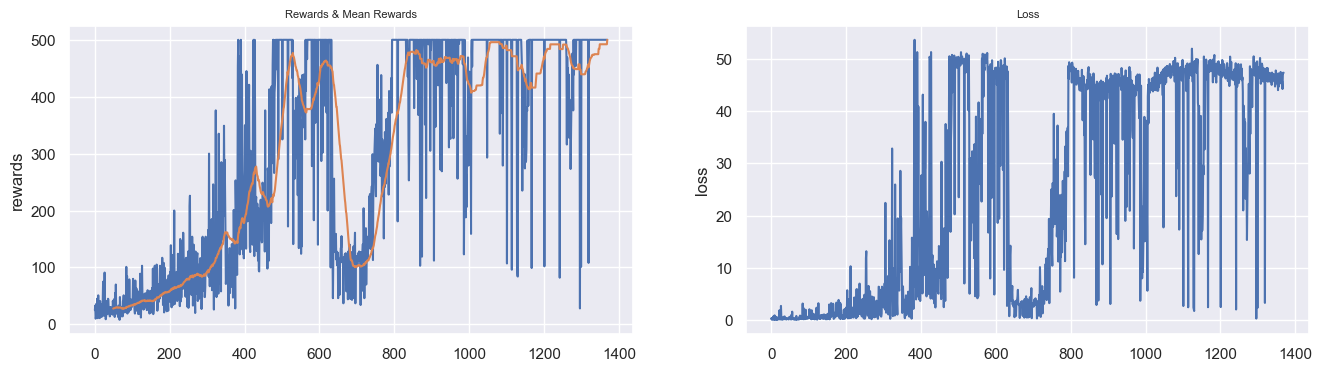

In [8]:
fig,ax=plt.subplots(1,2,sharex='col',sharey= False,figsize=(16,4))

sns.lineplot(df['rewards'], ax = ax[0])
sns.lineplot(df['mean_rewards'],ax = ax[0])
ax[0].set_title('Rewards & Mean Rewards',fontsize=8)

sns.lineplot(df['loss'],ax = ax[1])
ax[1].set_title('Loss',fontsize=8)

In [9]:
eval_env = gym.make(env_id,render_mode="human")

for epi in range(10):

    s = eval_env.reset()[0]
    term = False
    trunc = False
    score = 0

    while not any([term, trunc]):

        obs = T.FloatTensor(np.expand_dims(s,0)).to(device)

        with T.no_grad():
            p_vals = eval_agent.policy_net(obs)
            p_vals = T.squeeze(p_vals)

        p_vals = p_vals.detach().cpu().numpy()
        
        a = np.argmax(p_vals)
        s, r, term ,trunc , _  = eval_env.step(a)
       
        score+=r
        
    print(f'{epi = } result {score:4.2f}')
eval_env.close()

epi = 0 result 500.00
epi = 1 result 500.00
epi = 2 result 500.00
epi = 3 result 500.00
epi = 4 result 500.00
epi = 5 result 500.00
epi = 6 result 500.00
epi = 7 result 500.00
epi = 8 result 500.00
epi = 9 result 500.00
